In [1]:
DATAPATH = '../data/'
XFERPATH = '~/gdrive_files/twitgen/'  # To transfer files from Google Colab
TRAIN_FNAME = 'embed_train_201906020021.csv'
VALID_FNAME = 'embed_valid_201906020021.csv'
TEST_FNAME = 'embed_test_201906020021.csv'
LRP_TIMESTAMP = '201906021549'

In [2]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [3]:
# Get LRP predictions
fp_train = DATAPATH + 'lrp_train_pred_' + LRP_TIMESTAMP + '.csv'
lrp_train_pred = pd.read_csv(fp_train, index_col=['id','time'], parse_dates=['time'])

fp_valid = DATAPATH + 'lrp_valid_pred_' + LRP_TIMESTAMP + '.csv'
valid_pred = pd.read_csv(fp_valid, index_col=['id','time'], parse_dates=['time'])

fp_test = DATAPATH + 'lrp_test_pred_' + LRP_TIMESTAMP + '.csv'
test_pred = pd.read_csv(fp_test, index_col=['id','time'], parse_dates=['time'])

In [4]:
df_train = pd.read_csv(DATAPATH+TRAIN_FNAME, index_col=[0,1], parse_dates=['time'])
df_valid = pd.read_csv(DATAPATH+VALID_FNAME, index_col=[0,1], parse_dates=['time'])
df_test = pd.read_csv(DATAPATH+TEST_FNAME, index_col=[0,1], parse_dates=['time'])
df_train.head().iloc[:,:7]

,,male,embed0,embed1,embed2,embed3,embed4,embed5
id,time,,,,,,,
1083596943807393792,2019-05-27 23:27:08+00:00,True,-14081,80216,26727,19969,-5932,14983
815783987784187904,2019-05-24 15:36:01+00:00,False,-8092,-61741,24805,-21488,-20012,6800
3458239641,2019-05-24 19:00:37+00:00,False,-47872,-23766,28058,63213,9773,31955
1003729876250226688,2019-05-26 12:53:00+00:00,True,-16403,68003,17321,110208,4481,-44518
2360143940,2019-05-28 03:50:46+00:00,False,-11004,-11367,-47373,58910,31987,-48830


In [5]:
print(df_train.shape, df_valid.shape, df_test.shape)
print(df_train.index.get_level_values(1).min(), df_train.index.get_level_values(1).max())
print(df_valid.index.get_level_values(1).min(), df_valid.index.get_level_values(1).max())
print(df_test.index.get_level_values(1).min(), df_test.index.get_level_values(1).max())

(34146, 513) (10914, 513) (10450, 513)
2019-05-21 17:50:48+00:00 2019-05-28 12:44:26+00:00
2019-05-28 12:44:27+00:00 2019-05-30 12:09:54+00:00
2019-05-30 12:10:02+00:00 2019-06-01 19:55:43+00:00


In [6]:
def getxy(df):
    X = df.drop(['male'],axis=1).values / 1e6
    y = 1*df.male.values
    return(X, y)
    
X_train, y_train = getxy(df_train)
X_valid, y_valid = getxy(df_valid)
X_test, y_test = getxy(df_test)

In [7]:
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['objective'] = 'binary'
params['learning_rate'] = .025
params['sub_feature'] = .3
params['lambda_l1'] = 7
params['lambda_l2'] = 2
params['max_depth'] = 5

nboost=50

model = lgb.train(params, d_train, nboost)

In [8]:
y_train_pred = model.predict(X_train)
f1_score(y_train, y_train_pred>.5)

0.7076302167110228

In [9]:
y_pred = model.predict(X_valid)
print( confusion_matrix(y_valid, (y_pred>.5)) )
f1_score(y_valid, y_pred>.5)

[[3271 2186]
 [1939 3518]]


0.6304094615177851

In [10]:
accuracy_score(y_valid, y_pred>.5)

0.6220450797141286

In [11]:
frac = .5
combo_pred = frac*valid_pred.pred+(1-frac)*y_pred
accuracy_score(y_valid, combo_pred>.5)

0.6316657504123144

In [12]:
y_test_pred_lgb = model.predict(X_test)
accuracy_score(y_test, y_test_pred_lgb>.5)

0.6183732057416268

In [13]:
print( confusion_matrix(y_test, (y_test_pred_lgb>.5)) )
f1_score(y_test, y_test_pred_lgb>.5)

[[3138 2087]
 [1901 3324]]


0.6250470101541933

In [14]:
test_combo_pred = frac*test_pred.pred+(1-frac)*y_test_pred_lgb

print( confusion_matrix(y_test, (test_combo_pred>.5)) )
f1_score(y_test, test_combo_pred>.5)

[[3173 2052]
 [1869 3356]]


0.6312423586946299

In [15]:
accuracy_score(y_test, test_combo_pred>.5)

0.6247846889952153

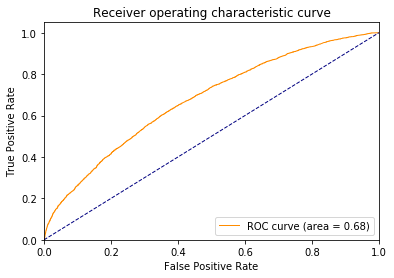

In [16]:
fpr, tpr, _ = roc_curve(y_test, test_combo_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
df_acc = pd.DataFrame(columns=['minprob','maxprob','count','accuracy'])
for pbot in np.linspace(0,.9,10):
    ptop = pbot+.1
    mask = (test_combo_pred>=pbot)&(test_combo_pred<ptop)
    count = int(mask.sum())
    acc = accuracy_score(y_test[mask], test_combo_pred[mask]>.5)
    row = pd.DataFrame({'minprob':[pbot], 'maxprob':[ptop], 'count':[count], 'accuracy':[acc]})
    df_acc = pd.concat([df_acc, row])
df_acc.set_index(['minprob','maxprob'])

/Users/andy/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)


,,count,accuracy
minprob,maxprob,,
0.0,0.1,0,NaN
0.1,0.2,212,0.867925
0.2,0.3,914,0.750547
0.3,0.4,1559,0.640154
0.4,0.5,2357,0.553670
0.5,0.6,2333,0.540506
0.6,0.7,1822,0.616905
0.7,0.8,879,0.732651
0.8,0.9,374,0.874332
